In [1]:
!module load python/3.6
import sys
# load your python virtual environment
sys.path.append("/home/u17/jiachuanxu/python3.6_virtualenv/lib/python3.6/site-packages")
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
def cov2cor(covs):
    cors = []
    for cov in covs:
        Ni, Nj = cov.shape[0], cov.shape[1]
        cor = np.zeros(cov.shape)
        for i in range(Ni):
            for j in range(Nj):
                if(cov[i,i] * cov[j,j] > 0):
                    cor[i,j] = cov[i,j] / np.sqrt(cov[i,i]*cov[j,j])
        cors.append(cor)
    return cors
def readCovmats(covs_fname, NG=True):
    covs = []
    for ct in range(len(covs_fname)):
        cov_data = np.genfromtxt(covs_fname[ct])
        Ndim = int(np.max(cov_data[:,0]) - np.min(cov_data[:,0])) + 1 
        print(f'Ndim = {Ndim}')
        cov = np.zeros((Ndim, Ndim))
        for line in range(cov_data.shape[0]):
            i, j = int(cov_data[line, 0]), int(cov_data[line, 1])
            if(cov_data.shape[1]==10):
                cg = cov_data[line, 8] if np.isfinite(cov_data[line, 8]) else 0.0
                cng = cov_data[line, 9] if np.isfinite(cov_data[line, 9]) else 0.0
                if(not np.isfinite(cov_data[line, 9])):
                    print("NG is not finite: i,j=%d,%d"%(i,j))
                if(not np.isfinite(cov_data[line, 8])):
                    print("G is not finite: i,j=%d,%d"%(i,j))
                if NG:
                    cov[i, j] = cg + cng
                    cov[j, i] = cg + cng
                else:
                    cov[i, j] = cg
                    cov[j, i] = cg
            elif(cov_data.shape[1]==3):
                cov[i, j] = cov_data[line, 2]
                cov[j, i] = cov_data[line, 2]
            else:
                print("ERROR: FORMAT UNRECOGNIZED")
                exit(-1)
        covs.append(cov)
    return covs
def maskCov(cov, mask):
    _cov = np.zeros(cov.shape)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            m = mask[i]*mask[j]
            if i==j and abs(m)<0.1:
                _cov[i,j] = cov[i,j]
            else:
                _cov[i,j] = cov[i,j]*m
    return _cov

# 1. Visualize Correlation Matrix

Covariance matrix information

`cov_y1xplanck_mix6x2pt_pp_p18cosmo_test_*`:

- Mix space 6x2pt: real-space $\xi_\pm(\theta)$, $\gamma_t(\theta)$, $w(\theta)$, $w_{gk}(\theta)$, $w_{sk}(\theta)$ and $C^{\kappa\kappa}(L)$ band-power
- Use noise file `./cmblensrec/plancksmica/cmb_lmax3000.txt` (the `ref` in the figure below), which is **less optimal** than the _Planck_ 2018 MV lensing reconstruction noise
<div>
<img src="figs/CMB_lensing_reconstruction_noise.png" width="500"/>
</div>
- Use the minimum-variance estimator dataset (binning matrix, covariance, etc.). The covariance matrix has been corrected for $\mathrm{Cov}\left( C^{\kappa\kappa}_L \right)=(\pi/2)^2\times \Sigma$
- Use the FFP10 fiducial $\Lambda$CDM parameters.
- Use the binning matrix $\mathcal{B}_i^L$ for cross-covariance between CMB lensing bandpower and other probes, and $\mathcal{B}_i^L+\mathcal{M}_i^{\phi,L}$ for CMB lensing bandpower auto-covariance (**Note: recommend using the public released Planck CMB lensing covariance matrix, the version marginalized over primary CMB info, and the Hartlap factor will be applied in Cocoa**)

**Actively used covariance matrix:**
- `cov_y1xplanck_mix6x2pt_pp_p18cosmo_test_withAnnulus`: consider the extended annulus when measuring $w_{gk/sk}$, consider the `healpy` pixel window function, consider the survey geometry effects on the Gaussian (NN-terms only) and non-Gaussian (connected trispectrum and SSC) covariance matrix.
- `cov_y1xplanck_mix6x2pt_pp_p18cosmo_test_withoutAnnulus`: does NOT consider the extended annulus when measuring $w_{gk/sk}$, consider the `healpy` pixel window function, consider the survey geometry effects on the Gaussian (NN-terms only) and non-Gaussian (connected trispectrum and SSC) covariance matrix.

**Deprecated covariace matrix:**

`cov_y1xplanck_mix6x2pt_pp_p18cosmo_nolincorr`:

- Mix space 6x2pt: real-space $\xi_\pm(\theta)$, $\gamma_t(\theta)$, $w(\theta)$, $w_{gk}(\theta)$, $w_{sk}(\theta)$ and $C^{\kappa\kappa}(L)$ band-power
- Use noise file `./cmblensrec/plancksmica/cmb_lmax3000.txt`, which is **less optimal** than the _Planck_ 2018 MV lensing reconstruction noise
- Use the minimum-variance estimator dataset (binning matrix, covariance, etc.). The covariance matrix has been corrected for $\mathrm{Cov}\left( C^{\kappa\kappa}_L \right)=(\pi/2)^2\times \Sigma$, and the Hartlap factor
- Use the FFP10 fiducial $\Lambda$CDM parameters.
- Use the binning matrix $\mathcal{B}_i^L$ for **BOTH** the cross-covariance between CMB lensing bandpower and other probes, and for CMB lensing bandpower auto-covariance.

In [3]:
covs_dir = "/home/u17/jiachuanxu/CosmoLike/DESxPlanck/covs/"
covs_dir_cocoa = "/home/u17/jiachuanxu/cocoa/Cocoa/projects/desy1xplanck/data/covmats/"
covs_fname = [
              #covs_dir_cosmolike+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_consext8_withAnnulus",
              #covs_dir_cosmolike+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_consext8_withoutAnnulus",
              #covs_dir+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_agr2_withAnnulus_kkkkSimDR3",
              #covs_dir_cosmolike+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_agr2_withAnnulus",
              #covs_dir_cosmolike+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_agr2_withoutAnnulus",
              #covs_dir+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_consext8_withAnnulus_kkkkSimDR3",
              covs_dir+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_agr2_withAnnulus_kkkkSimDR3",
              covs_dir+"cov_y1xplanck_mix6x2pt_pp_p18cosmo_agr2_withAnnulus_notaper",
             ]
covs = readCovmats(covs_fname)
#covs_G = readCovmats(covs_fname, NG=False)
# replace the cov by Planck cov
if False:
    #Ckk_cov = np.genfromtxt("../cmblensrec/plancksmica/dr4_consext8_CMBmarged/Ckk_bandpower_covariance.txt")
    Ckk_cov = np.genfromtxt("../cmblensrec/plancksmica/pp_agr2_CMBmarged/Ckk_bandpower_covariance.txt")
    #Ckk_cov = np.genfromtxt("../cmblensrec/plancksmica/pp_consext8_CMBmarged/Ckk_bandpower_covariance.txt")
    print(Ckk_cov.shape)
    suffix = "_kkkkSimDR3"
    for ct,cov in enumerate(covs):
        _start = cov.shape[0] - Ckk_cov.shape[0]
        cov[_start:,_start:] = Ckk_cov
        with open(covs_fname[ct]+suffix, 'w') as fp:
            for i in range(cov.shape[0]):
                for j in range(i, cov.shape[1]):
                    fp.write("%d %d %le\n"%(i,j,cov[i,j]))
        print("Save combined covmat to %s"%covs_fname[ct]+suffix)
cors = cov2cor(covs)
#cors_G = cov2cor(covs_G)

Ndim = 1094
Ndim = 1094


In [4]:
Ntheta = 20
Nbp_agr2 = 14
Nbp_consext8 = 9
Nlens = 5
Nsrc = 4

Nss = Ntheta*( (Nsrc+1)*Nsrc )
Ngs = Ntheta*( Nsrc*Nlens )
Ngg = Ntheta*( Nlens )
Ngk = Ntheta*( Nlens )
Nsk = Ntheta*( Nsrc )

Ndata_3x2pt = Nss+Ngs+Ngg
Ndata_5x2pt = Nss+Ngs+Ngg+Nsk+Ngk
Ndata_6x2pt_agr2 = Nss+Ngs+Ngg+Nsk+Ngk+Nbp_agr2
Ndata_6x2pt_consext8 = Nss+Ngs+Ngg+Nsk+Ngk+Nbp_consext8

print("N6x2pt = %d, N3x2pt = %d"%(Ndata_6x2pt_consext8, Ndata_3x2pt))

N6x2pt = 1089, N3x2pt = 900


## 1.1 Zoom-in plot showing the correlation matrix

max_range = 1.000000e+00


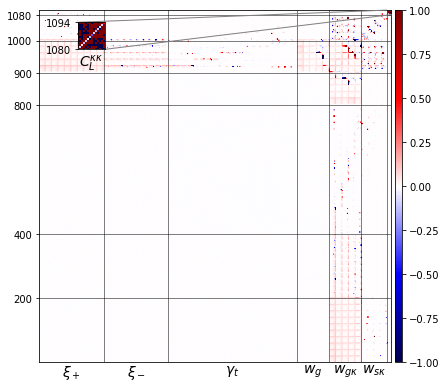

In [8]:
fig = plt.figure(figsize=(6.5, 6.5))
#ax = fig.add_axes([0.135, 0.125, 0.89, 0.88])

### Set data to show
### ================
data_to_show = covs[0]/covs[1]-1
#Ndata_6x2pt = Ndata_6x2pt_consext8
Ndata_6x2pt = Ndata_6x2pt_agr2

#max_range = np.max(abs(data_to_show))
max_range = 1
print("max_range = %e"%max_range)
### Plot corr mat
### =============
cb = plt.imshow(data_to_show, origin="lower", cmap='seismic', 
                vmin=-max_range,vmax=max_range,
               )
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(cb, cax=cax)

#print(ax.get_position())
#print(ax.get_position())

### Plot segmentations
### ==================
# xi_+
ax.axvline(Nss/2-0.5, lw=0.5, color='k')
ax.axhline(Nss/2-0.5, lw=0.5, color='k')
# xi_-
ax.axvline(Nss-0.5, lw=0.5, color='k')
ax.axhline(Nss-0.5, lw=0.5, color='k')
# gs
ax.axvline(Nss+Ngs-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs-0.5, lw=0.5, color='k')
# gg
ax.axvline(Nss+Ngs+Ngg-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs+Ngg-0.5, lw=0.5, color='k')
# gk
ax.axvline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
# sk
ax.axvline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=0.5, color='k')
ax.axhline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=0.5, color='k')

### Annotate probes
### ===============
fs = 14
Npad = -2
ax.text(Nss/2/2, Npad, 
        r'$\xi_+$', ha='center', va='top', fontsize=fs)
ax.text((Nss/2 + Nss)/2, Npad, 
        r'$\xi_-$', ha='center', va='top', fontsize=fs)
ax.text((Nss + Nss+Ngs)/2, Npad, 
        r'$\gamma_t$', ha='center', va='top', fontsize=fs)
ax.text((Nss+Ngs + Nss+Ngs+Ngg)/2, Npad, 
        r'$w_g$', ha='center', va='top', fontsize=fs)
ax.text((Ndata_3x2pt + Ndata_3x2pt+Ngk)/2, Npad, 
        r'$w_{g\kappa}$', ha='center', va='top', fontsize=fs)
ax.text((Ndata_3x2pt+Ngk + Ndata_3x2pt+Ngk+Nsk)/2, Npad, 
        r'$w_{s\kappa}$', ha='center', va='top', fontsize=fs)
ax.set_xticks([])
ax.set_yticks([Nss//2-0.5, Nss-0.5, Nss+Ngs-0.5, Ndata_3x2pt-0.5, Ndata_3x2pt+Ngk-0.5, Ndata_3x2pt+Ngk+Nsk-0.5],)
ax.set_yticklabels([Nss//2, Nss, Nss+Ngs, Ndata_3x2pt, Ndata_3x2pt+Ngk, Ndata_3x2pt+Ngk+Nsk])

### Zoom-in panel
### =============
axins = zoomed_inset_axes(ax, 6, 
                          bbox_to_anchor=(0.2, 0.98),
                         bbox_transform=ax.transAxes) # zoom = 6
axins.imshow(data_to_show, interpolation="nearest",
             origin="lower",cmap='seismic', vmin=-max_range,vmax=max_range,)
# sub region of the original image
x1, x2, y1, y2 = Ndata_5x2pt, Ndata_6x2pt, Ndata_5x2pt, Ndata_6x2pt
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([Ndata_5x2pt, Ndata_6x2pt])
axins.text((Ndata_3x2pt+Ngk+Nsk + Ndata_6x2pt)/2, Ndata_5x2pt+Npad, 
           r'$C^{\kappa\kappa}_L$', ha='center', va='top', fontsize=fs)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()

### If show data vector difference
### ==============================
show_datav_diff = False
if show_datav_diff:
    subax = fig.add_axes([0.14, 0.05, 0.88, 0.07])
    print(subax.get_position())
    subax.scatter(range(Ndata_6x2pt)[Ndata_3x2pt:Ndata_6x2pt-Nkk], diff[Ndata_3x2pt:Ndata_6x2pt-Nkk], 
                   s=1, label='tSZcontm-tSZdeproj')
    subax.scatter(range(Ndata_6x2pt)[Ndata_3x2pt:Ndata_6x2pt-Nkk], diff_tSZref[Ndata_3x2pt:Ndata_6x2pt-Nkk], 
                  s=1, label='ref-tSZdeproj')
    subax.scatter(range(Ndata_6x2pt)[:Ndata_3x2pt], diff_treecorr[:Ndata_3x2pt], 
                  s=1, label='TreeCorr-Pub')
    subax.legend(loc='lower left')
    # xi_+
    subax.axvline(Nss/2-0.5, lw=0.5, color='k')
    # xi_-
    subax.axvline(Nss-0.5, lw=0.5, color='k')
    # gs
    subax.axvline(Nss+Ngs-0.5, lw=0.5, color='k')
    # gg
    subax.axvline(Nss+Ngs+Ngg-0.5, lw=0.5, color='k')
    # gk
    subax.axvline(Nss+Ngs+Ngg+Ngk-0.5, lw=0.5, color='k')
    # sk
    subax.axvline(Nss+Ngs+Ngg+Ngk+Nsk-0.5, lw=0.5, color='k')
    subax.set_xlim(ax.get_xlim())


plt.show()
#plt.tight_layout()
#plt.savefig("CorrMat_pp_agr2_ref_CkkCkk_FFP10.pdf")

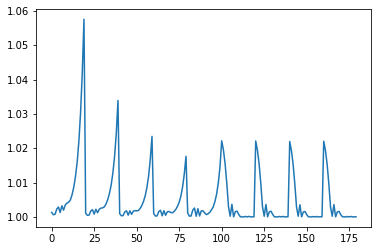

In [11]:
plt.plot( (np.diag(covs[0])/np.diag(covs[1]))[900:1080])

In [10]:
w, v = np.linalg.eig(cors[0][:920,:920])

In [11]:
np.max(w)/np.min(w)

-210259612.58996823

In [6]:
import astropy.io.fits as fits
root = "/groups/timeifler/jiachuanxu/des_y1/data_vector"
hdul = fits.open(root+"/2pt_NG_mcal_1110.fits")
cov_pub = hdul[1].data

In [ ]:
plt.imshow()

In [8]:
ratio = cov_pub/covs[1][:900,:900]

(0.0, 400.0)

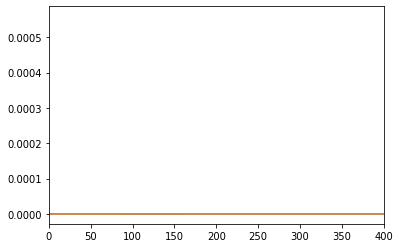

In [15]:
plt.plot(np.diag(cov_pub))
plt.plot(np.diag(covs[1][:900,:900]))
plt.xlim([0,400])

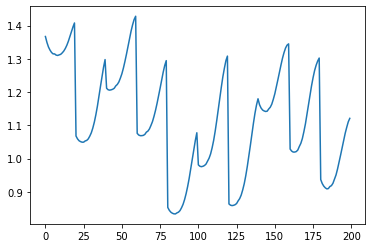

In [18]:
plt.plot(np.diag(ratio[:200])**-1)

(0.0, 1.0)

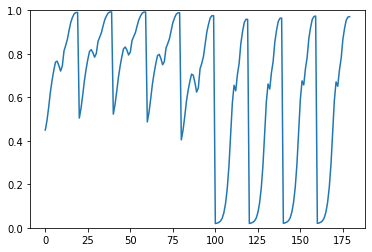

In [43]:
noise_consext8 = np.diagonal(covs[1])**0.5
noise_agr2 = np.diagonal(covs[7])**0.5
ratio = noise_consext8[900:1080]/noise_agr2[900:1080]
plt.plot(ratio)
plt.ylim([0,1])

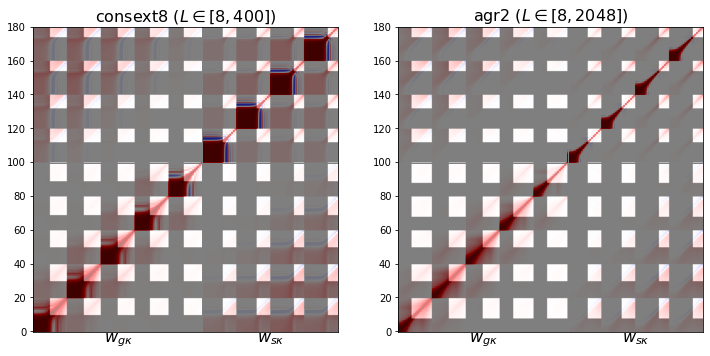

In [57]:
# read masks
mask_dir = "/home/u17/jiachuanxu/cocoa/Cocoa/projects/desy1xplanck/data/masks/"

mask_consext8 = np.genfromtxt(mask_dir+"xi_desy1xplanck_6x2pt_realdata_pp_consext8_CMBmarged.mask")[900:1080,1]
mask_agr2     = np.genfromtxt(mask_dir+"xi_desy1xplanck_6x2pt_realdata_pp_agr2_CMBmarged.mask")[900:1080,1]

fig, axes = plt.subplots(1,2,figsize=(12,6))

mask_map_consext8 = np.zeros([180,180])
for i in range(180):
    for j in range(180):
        mask_map_consext8[i,j] = mask_consext8[i] * mask_consext8[j]
axes[0].imshow(cors[0][900:1080,900:1080], origin='lower', cmap='seismic', vmin=-1, vmax=1)
axes[0].imshow(mask_map_consext8, cmap='gray', vmin=0, vmax=1, alpha=0.5, origin='lower')
axes[0].axvline(100-0.5, lw=1, color='grey')
axes[0].axhline(100-0.5, lw=1, color='grey')
axes[0].set(xticks=[], yticks=np.arange(0,200,20), )
axes[0].set_title(r'consext8 ($L\in[8,400]$)', fontsize=16)
axes[0].text(50,0,r'$w_{g\kappa}$', fontsize=16, ha='center', va='top')
axes[0].text(140,0,r'$w_{s\kappa}$', fontsize=16, ha='center', va='top')

mask_map_agr2 = np.zeros([180,180])
for i in range(180):
    for j in range(180):
        mask_map_agr2[i,j] = mask_agr2[i] * mask_agr2[j]
axes[1].imshow(cors[1][900:1080,900:1080], origin='lower', cmap='seismic', vmin=-1, vmax=1)
axes[1].imshow(mask_map_agr2, cmap='gray', vmin=0, vmax=1, alpha=0.5, origin='lower')
axes[1].axvline(100-0.5, lw=1, color='grey')
axes[1].axhline(100-0.5, lw=1, color='grey')
axes[1].set(xticks=[], yticks=np.arange(0,200,20), )
axes[1].set_title(r'agr2 ($L\in[8,2048]$)', fontsize=16)
axes[1].text(50,0,r'$w_{g\kappa}$', fontsize=16, ha='center', va='top')
axes[1].text(140,0,r'$w_{s\kappa}$', fontsize=16, ha='center', va='top')

plt.savefig('figs/gksk_corrmat_compare.pdf')
#plt.show()

## 1.2 Show the different betweem covariance matrice with and without extended annulus modeling.

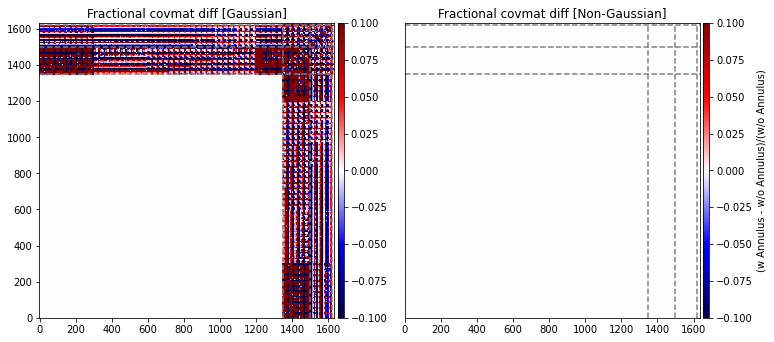

In [15]:
fig, axes = plt.subplots(1,2,figsize=(12,6))

cb = axes[0].imshow( (covs_G[1]-covs_G[0])/covs[0], 
                    origin='lower', cmap='seismic', 
                    vmin=-0.1,vmax=0.1)
axes[0].set(title='Fractional covmat diff [Gaussian]')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(cb, cax=cax)
for delim in [1350, 1500, 1620]:
    axes[0].axhline(delim-0.5, ls='--', color='grey')
    axes[0].axvline(delim-0.5, ls='--', color='grey')

cb = axes[1].imshow( (covs[1]-covs_G[1]-covs[0]+covs_G[0])/covs[0], 
                    origin='lower', cmap='seismic', 
                    #vmin=-0.01,vmax=0.01
                   )
axes[1].set(title='Fractional covmat diff [Non-Gaussian]', yticks=[])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(cb, cax=cax, label='(w Annulus - w/o Annulus)/(w/o Annulus)')
for delim in [1350, 1500, 1620]:
    axes[1].axhline(delim-0.5, ls='--', color='grey')
    axes[1].axvline(delim-0.5, ls='--', color='grey')

plt.show()

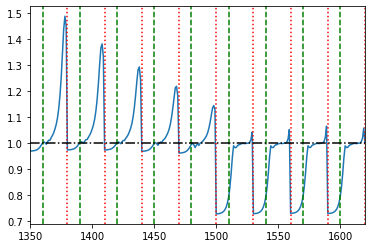

In [27]:
ratio = np.sqrt(np.diag(covs[1])/np.diag(covs[0]))

plt.plot(ratio, label=r'$L\in[8,2048]$ / orignal')

plt.xlim([1350, 1620])
for i in range(1,10):
    plt.axvline(1350+30*i-20, ls='--', c='green')
    plt.axvline(1350+30*i, ls=':', c='red')
plt.axhline(1, ls='-.', color='k')

## 1.3 Show whether the covariance matrix is positive-definite

In [13]:
# read mask
cocoa_dir = "/home/u17/jiachuanxu/cocoa/Cocoa/projects"
mask = np.genfromtxt(cocoa_dir+'/desy1xplanck/data/masks/xi_desy1xplanck_6x2pt_realdata_pp_agr2_CMBmarged_ssExt_025.mask')[:,1]
#mask = np.ones(1094)
for cov in covs:
    _cov = cov.copy()
    for i in range(_cov.shape[0]):
        for j in range(_cov.shape[1]):
            _m = mask[i] * mask[j]
            _cov[i,j] *= _m
            if(i==j and _m==0):
                _cov[i,j] = 1
    ev = np.sort(np.linalg.eigvals(_cov))
    print(f'Any eigenvalues <= 0? {any(ev<=0)}')

Any eigenvalues <= 0? False
Any eigenvalues <= 0? False


## 1.4 [Optional] Covariance matrix when $\xi_{\pm}$ is extended to 0.25 arcmin



In [66]:
fname = covs_dir+"cov_y1xplanck_mix6x2pt_Ntheta30_pp_p18cosmo_test_withAnnulus"

cov_data = np.genfromtxt(fname)
Ndim = int(np.max(cov_data[:,0]) - np.min(cov_data[:,0])) + 1 
print(f'Ndim = {Ndim} [{np.min(cov_data[:,0])}, {np.max(cov_data[:,0])}]')
Ndim_new = 30*((Nsrc+1)*Nsrc) + 20*(Nsrc*Nlens + Nlens + Nlens + Nsrc) + Nbp_agr2
NG = True
cov = np.zeros((Ndim_new, Ndim_new))
mask = np.zeros((Ndim,Ndim))
_m = np.zeros(Ndim, dtype=int)
ct = 0
for i in range(Ndim):
    if i< 30*(Nsrc+1)*Nsrc:
        _m[i] = ct
        ct += 1
    elif (i < Ndim - Nbp_agr2):
        if (i%30 < 10):
            _m[i] = -1
        else:
            _m[i] = ct
            ct += 1
    else:
        _m[i] = ct
        ct += 1
print(ct)
for line in range(cov_data.shape[0]):
    i, j = int(cov_data[line, 0]), int(cov_data[line, 1])
    theta_i = i%30; theta_j = j%30
    ss_i = i<30*(Nsrc+1)*Nsrc
    ss_j = j<30*(Nsrc+1)*Nsrc
    kk_i = i>= Ndim-Nbp_agr2
    kk_j = j>= Ndim-Nbp_agr2
    skip_i = theta_i < 10 and (not ss_i) and (not kk_i)
    skip_j = theta_j < 10 and (not ss_j) and (not kk_j)
    mask[i,j] = skip_i or skip_j
    _i, _j = _m[i], _m[j]
    if _i>=0 and _j>=0:
        #print(_i, _j)
        if(cov_data.shape[1]==10):
            cg = cov_data[line, 8] if np.isfinite(cov_data[line, 8]) else 0.0
            cng = cov_data[line, 9] if np.isfinite(cov_data[line, 9]) else 0.0
            if(not np.isfinite(cov_data[line, 9])):
                print("NG is not finite: i,j=%d,%d"%(i,j))
            if(not np.isfinite(cov_data[line, 8])):
                print("G is not finite: i,j=%d,%d"%(i,j))
            if NG:
                cov[_i, _j] = cg + cng
                cov[_j, _i] = cg + cng
            else:
                cov[_i, _j] = cg
                cov[_j, _i] = cg
        elif(cov_data.shape[1]==3):
            cov[_i, _j] = cov_data[line, 2]
            cov[_j, _i] = cov_data[line, 2]
        else:
            print("ERROR: FORMAT UNRECOGNIZED")
            exit(-1)
if True:
    #Ckk_cov_dr4 = np.genfromtxt("../cmblensrec/plancksmica/dr4_consext8_CMBmarged/Ckk_bandpower_covariance.txt")
    Ckk_cov = np.genfromtxt("../cmblensrec/plancksmica/pp_agr2_CMBmarged/Ckk_bandpower_covariance.txt")
    print(Ckk_cov.shape)
    suffix = "_kkkkSimDR3"
    
    _start = cov.shape[0] - Ckk_cov.shape[0]
    cov[_start:,_start:] = Ckk_cov
    _fn = covs_dir+"cov_y1xplanck_mix6x2pt_Nthetass30_pp_p18cosmo_test_withAnnulus"+suffix
    with open(_fn, 'w') as fp:
        for i in range(cov.shape[0]):
            for j in range(cov.shape[1]):
                fp.write("%d %d %le\n"%(i,j,cov[i,j]))
    print("Save combined covmat to %s"%_fn)
cor = cov2cor([cov])[0]

Ndim = 1634 [0.0, 1633.0]
1294
(14, 14)
Save combined covmat to /home/u17/jiachuanxu/CosmoLike/DESxPlanck/covs/cov_y1xplanck_mix6x2pt_Nthetass30_pp_p18cosmo_test_withAnnulus_kkkkSimDR3


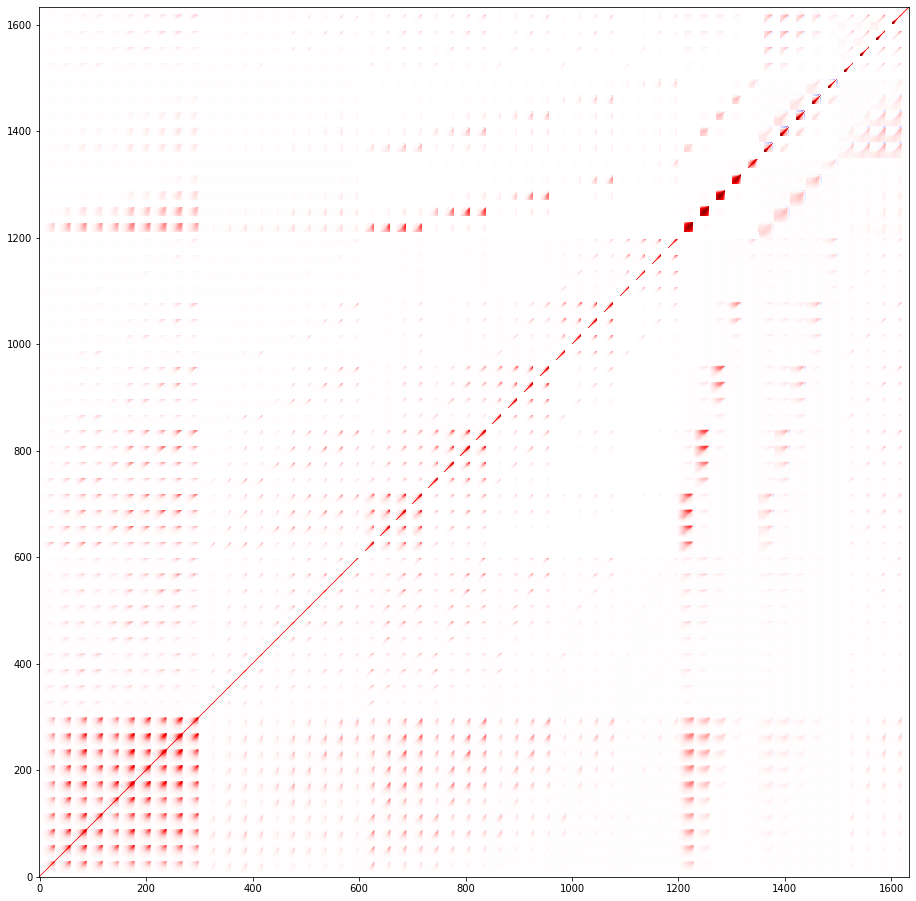

In [67]:
fig = plt.figure(figsize=(16,16))
plt.imshow(np.ma.masked_array(cors[2], mask), origin='lower', vmin=-1, vmax=1, cmap='seismic')

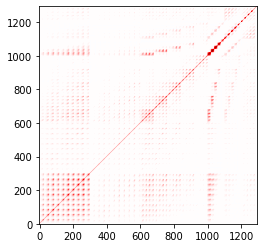

In [68]:
plt.imshow(cor, origin='lower', cmap='seismic', vmin=-1, vmax=1)

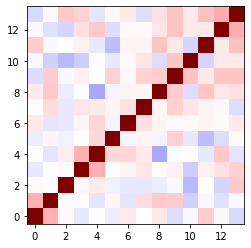

In [69]:
plt.imshow(cor[-14:,-14:], origin='lower', vmin=-1, vmax=1, cmap='seismic')

# 2. [deprecated] CMB lensing convergence covmat: compare between Planck DR and CosmoLike

1.0669642857142858


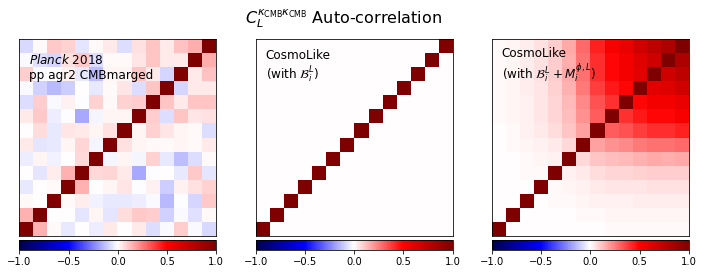

In [7]:
cov_merge = np.zeros((15,15))
cor_merge = np.zeros((14,14))

cov_kk_cosmolike = covs[1][Ndata_5x2pt:, Ndata_5x2pt:]
cov_kk_cosmolike_corr = covs[0][Ndata_5x2pt:, Ndata_5x2pt:]

Nvar, Nbins = 240, 14
hartlap_factor = (Nvar - Nbins - 2)/(Nvar - 1)
#hartlap_factor = 1
print(1/hartlap_factor)
cov_kk_planck_CMBmarg = np.genfromtxt("../cmblensrec/plancksmica/pp_agr2_CMBmarged/Ckk_bandpower_covariance.txt")
#cov_kk_planck_CMBmarg /= hartlap_factor
cov_kk_planck = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/PlanckLensingLikelihood/planck_lensing_2018/"+\
                             "smicadx12_Dec5_ftl_mv2_ndclpp_p_teb_agr2_cov.dat").reshape((14,14))*(np.pi/2)**2#/hartlap_factor

cor_kk_cosmolike = cov2cor(cov_kk_cosmolike)
cor_kk_cosmolike_corr = cov2cor(cov_kk_cosmolike_corr)
cor_kk_planck = cov2cor(cov_kk_planck)
cor_kk_planck_CMBmarg = cov2cor(cov_kk_planck_CMBmarg)


fig, axes = plt.subplots(1,3, figsize=(12,4))
fig.suptitle("$C^{\kappa_{\mathrm{CMB}}\kappa_\mathrm{CMB}}_L$ Auto-correlation", fontsize=16)
cb = axes[0].imshow(cor_kk_planck_CMBmarg, origin='lower', cmap='seismic', vmin=-1, vmax=1)
axes[0].text(0.05, 0.8, '$Planck$ 2018\npp agr2 CMBmarged', transform=axes[0].transAxes,
            fontsize=12)
axes[0].set(xticks=[], yticks=[])
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[1].imshow(cor_kk_cosmolike, origin='lower', cmap='seismic', vmin=-1, vmax=1)
axes[1].text(0.05,0.8,"CosmoLike\n(with $\mathcal{B}_i^L$)", transform=axes[1].transAxes,
            fontsize=12)
axes[1].set(xticks=[], yticks=[])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax, orientation='horizontal')

cb = axes[2].imshow(cor_kk_cosmolike_corr, origin='lower', cmap='seismic', vmin=-1, vmax=1)
divider = make_axes_locatable(axes[2])
axes[2].text(0.05, 0.8, "CosmoLike\n(with $\mathcal{B}_i^L+M_i^{\phi,L}$)", transform=axes[2].transAxes,
            fontsize=12)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
axes[2].set(xticks=[], yticks=[])
plt.colorbar(cb, cax=cax, orientation='horizontal')

#plt.savefig("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/cov_kkkk_debug/cor_compare.png", dpi=300)
plt.show()

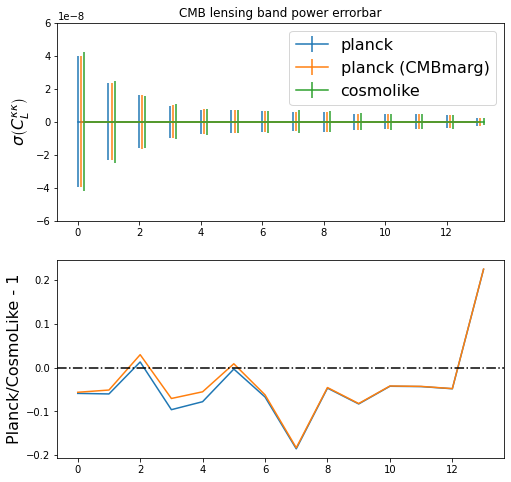

In [8]:
fig, axes = plt.subplots(2,1, figsize=(8,8))

axes[0].errorbar(np.array(range(14)), np.zeros(14), 
                 yerr=np.sqrt(np.diagonal(cov_kk_planck)), label='planck')
axes[0].errorbar(np.array(range(14))+0.1, np.zeros(14), 
                 yerr=np.sqrt(np.diagonal(cov_kk_planck_CMBmarg)), label='planck (CMBmarg)')
axes[0].errorbar(np.array(range(14))+0.2, np.zeros(14), 
                 yerr=np.sqrt(np.diagonal(cov_kk_cosmolike)), label='cosmolike')

axes[0].set_ylim([-6e-8, 6e-8])
axes[0].legend(fontsize=16)
axes[0].set_title("CMB lensing band power errorbar")
axes[0].set_ylabel(r'$\sigma\left(C^{\kappa\kappa}_L\right)$', fontsize=16)

axes[1].plot(range(14), np.sqrt(np.diagonal(cov_kk_planck))/(np.sqrt(np.diagonal(cov_kk_cosmolike)))-1,)
axes[1].plot(np.array(range(14)), np.sqrt(np.diagonal(cov_kk_planck_CMBmarg))/(np.sqrt(np.diagonal(cov_kk_cosmolike)))-1,)

axes[1].axhline(0,ls='-.',c='k')
axes[1].set_ylabel('Planck/CosmoLike - 1', fontsize=16)
plt.show()

# [pass] Check likelihood difference between data vectors

In [105]:
# 2pt functions output
twopt_dir = "/home/u17/jiachuanxu/CosmoLike/2pt_measurements/data_test"

# data vector angular mask file


# 3x2pt data vectors measured by TreeCorr
datav_gg = twopt_dir+'/gg_%d_%d.txt'
datav_gs = twopt_dir+'/ggl_S%d_L%d.txt'
datav_ss = twopt_dir+'/shear_%d_%d.txt'

# gk, sk data vectors measured from planck reference smoothed map
datav_gk_tSZref = twopt_dir+'/gk_smooth_%d.txt'
datav_sk_tSZref = twopt_dir+'/sk_smooth_%d.txt'

# gk, sk data vectors measured from planck tSZ-contaminated smoothed map
datav_gk_tSZcontm = twopt_dir+'/gk_SZctm_smooth_%d.txt'
datav_sk_tSZcontm = twopt_dir+'/sk_SZctm_smooth_%d.txt'

# gk, sk data vectors measured from planck tSZ-deprojected smoothed map
datav_gk_tSZdeproj = twopt_dir+'/gk_SZdeproj_smooth_%d.txt'
datav_sk_tSZdeproj = twopt_dir+'/sk_SZdeproj_smooth_%d.txt'

In [127]:
gk_mask = [
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          ]
sk_mask = [
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
          ]
_DESY1_3x2pt_mask = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/2pt_meas"\
                                 "urements/data_test/xi_desy1_3x2pt_treecorr_test.mask")
DESY1_3x2pt_mask = np.zeros(Ndata)
DESY1_3x2pt_mask[:Ndata_3x2pt] = _DESY1_3x2pt_mask[:,1]

## 1. 6x2pt Data vector measured using Planck reference map and Planck tSZ-deprojected map

In [111]:
datav_tSZcontm = np.zeros(Ndata)
datav_tSZdeproj = np.zeros(Ndata)
start = int(Ntheta*( (Nsrc+1)*Nsrc/2 + (Nsrc+1)*Nsrc/2 + Nsrc*Nlens + Nlens))
print("CMB-related real-sapce datav starts at %d"%start)
# gk start
for i in range(Nlens):
    gk_tSZcontm = np.genfromtxt(datav_gk_tSZcontm%i, names=True)
    gk_tSZdeproj = np.genfromtxt(datav_gk_tSZdeproj%i, names=True)
    datav_tSZcontm[start:start+Ntheta] = gk_tSZcontm['xi'] * gk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = gk_tSZdeproj['xi'] * gk_mask[i]
    start += Ntheta
# sk start
for i in range(Nsrc):
    sk_tSZcontm = np.genfromtxt(datav_sk_tSZcontm%i, names=True)
    sk_tSZdeproj = np.genfromtxt(datav_sk_tSZdeproj%i, names=True)
    datav_tSZcontm[start:start+Ntheta] = sk_tSZcontm['xi'] * sk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = sk_tSZdeproj['xi'] * sk_mask[i]
    start += Ntheta
print("CMB-related real-sapce datav ends at %d"%start)
# calculate difference in likelihood
diff = datav_tSZcontm - datav_tSZdeproj
loglike_diff = -0.5*diff.T@invcov@diff
print("Difference in log(likelihood) between tSZ-contamintaed "\
      "and tSZ-deprojected gk+sk data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between tSZ-contaminated and"\
      " tSZ-deprojected gk+sk data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

CMB-related real-sapce datav starts at 900
CMB-related real-sapce datav ends at 1080
Difference in log(likelihood) between tSZ-contamintaed and tSZ-deprojected gk+sk data vectors = -426.76
Difference in chi2 per dof between tSZ-contaminated and tSZ-deprojected gk+sk data vectors >= 4.74


## 2. 3x2pt Data vector measured using TreeCorr code and the public data vector

In [128]:
datav_treecorr = np.zeros(Ndata)
datav_public = np.zeros(Ndata)
_datav_treecorr = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/datav/xi_Y1_3x2pt_treecorr_test")
_datav_public = np.genfromtxt("/home/u17/jiachuanxu/CosmoLike/DESxPlanck/datav/xi_Y1_3x2pt_public")
datav_treecorr[0:Ndata_3x2pt] = _datav_treecorr[:,1]
datav_public[0:Ndata_3x2pt] = _datav_public[:,1]
# calculate difference in likelihood
diff_treecorr = (datav_treecorr - datav_public)*DESY1_3x2pt_mask
loglike_diff = -0.5*diff_treecorr.T@invcov@diff_treecorr
print("Difference in log(likelihood) between TreeCorr "\
      "and Public 3x2pt data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between TreeCorr and"\
      " public 3x2pt data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

Difference in log(likelihood) between TreeCorr and Public 3x2pt data vectors = -2.42
Difference in chi2 per dof between TreeCorr and public 3x2pt data vectors >= 0.03


In [112]:
datav_tSZref = np.zeros(Ndata)
datav_tSZdeproj = np.zeros(Ndata)
start = int(Ntheta*( (Nsrc+1)*Nsrc/2 + (Nsrc+1)*Nsrc/2 + Nsrc*Nlens + Nlens))
print("CMB-related real-sapce datav starts at %d"%start)
# gk start
for i in range(Nlens):
    gk_tSZref = np.genfromtxt(datav_gk_tSZref%i, names=True)
    gk_tSZdeproj = np.genfromtxt(datav_gk_tSZdeproj%i, names=True)
    datav_tSZref[start:start+Ntheta] = gk_tSZref['xi'] * gk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = gk_tSZdeproj['xi'] * gk_mask[i]
    start += Ntheta
# sk start
for i in range(Nsrc):
    sk_tSZref = np.genfromtxt(datav_sk_tSZref%i, names=True)
    sk_tSZdeproj = np.genfromtxt(datav_sk_tSZdeproj%i, names=True)
    datav_tSZref[start:start+Ntheta] = sk_tSZref['xi'] * sk_mask[i]
    datav_tSZdeproj[start:start+Ntheta] = sk_tSZdeproj['xi'] * sk_mask[i]
    start += Ntheta
print("CMB-related real-sapce datav ends at %d"%start)
# calculate difference in likelihood
diff_tSZref = datav_tSZref - datav_tSZdeproj
loglike_diff = -0.5*diff_tSZref.T@invcov@diff_tSZref
print("Difference in log(likelihood) between reference "\
      "and tSZ-deprojected gk+sk data vectors = {:.2f}".format(loglike_diff))
print("Difference in chi2 per dof between reference and"\
      " tSZ-deprojected gk+sk data vectors >= {:.2f}".format(-2*loglike_diff/(Ngk+Nsk)))

CMB-related real-sapce datav starts at 900
CMB-related real-sapce datav ends at 1080
Difference in log(likelihood) between reference and tSZ-deprojected gk+sk data vectors = -559.73
Difference in chi2 per dof between reference and tSZ-deprojected gk+sk data vectors >= 6.22
